# CSCE 479/879 Hackathon: Recurrent Models

Written by Eleanor Quint

Modified by Mrinal rawool and Stephen Scott

In [ ]:
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops

DATA_DIR = './tensorflow-datasets/'

#### RNN/LSTM recap

Recurrent neural networks (RNNs) are computation graphs with loops (i.e., not directed acyclic graphs). Because the backpropagation algorithm only works with DAGs, we have to unroll the RNN through time. Tensorflow provides code that handles this automatically.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="80%">


The most common RNN unit is the LSTM, depicted below:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width="80%">

We can see that each unit takes 3 inputs and produces 3 outputs, two which are forwarded to the same unit at the next timestep and one true output, $h_t$ depicted coming out of the top of the cell.

The upper right output going to the next timestep is the cell state. It carries long-term information between cells, and is calculated as:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png" width="80%">

where the first term uses the forget gate $f_t$ to decide to scale the previous state (potentially making it smaller to "forget" it), and the second term is the product of the update gate $i_t$ and the state update $\tilde{C}_t$. Each of the forget and update gates are activated with sigmoid, so their range is (0,1).

The true output and the second, lower output on the diagram are calculated by the output gate:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png" width="80%">

First, $o_t$ is calculated from the output of the previous timestep concatenated with the current input, but then it's mixed with the cell state to get the true output. Passing on this output to the next timestep as the hidden state gives the unit a kind of short term memory.

(Images sourced from [Colah's Blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/))

#### Demo: Sentiment Classification using IMdb

Today, we're going to teach a recurrent model how to classify sentiment by inputting a sequence of words and asking the model to estimate what the sentiment is. The IMDB review dataset has the text of movie reviews and a label for whether the review is negative (zero) or positive (one). First, we'll load the dataset and then set up a preprocessor to turn the words into integers using `tf.keras.layers.experimental.preprocessing.TextVectorization`.

### Step 1: Download and examine the dataset



In [110]:
# load the text dataset
ds = tfds.load('imdb_reviews', data_dir=DATA_DIR)
ds

{'train': <_PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>,
 'test': <_PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>,
 'unsupervised': <_PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>}

In [ ]:
ds_train = ds["train"].take(1)
for item in ds_train:
    print(item["text"], "\n", item["label"].numpy())

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string) 
 0


### Step 2: Create vectorization layer

to create a word <=> integer mapping


In [ ]:
# vectorization hyperparams
MAX_SEQ_LEN = 128
MAX_TOKENS = 5000

# Create TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=MAX_TOKENS,
                                                    # standardize='lower_and_strip_punctuation',
                                                    # split='whitespace',
                                                    # ngrams=None,
                                                    # output_mode='int', # options: "int", "multi_hot", "count" or "tf_idf"
                                                    output_sequence_length=MAX_SEQ_LEN,
                                                    # pad_to_max_tokens=False,
                                                    # vocabulary=None,
                                                    # idf_weights=None,
                                                    # sparse=False,
                                                    # ragged=False,
                                                    # encoding='utf-8',
                                                    # **kwargs
                                                    )

 When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a vocabulary from them.

In [ ]:
# Use `adapt` to create a vocabulary mapping words to integers
train_text = ds['train'].map(lambda x: x['text'])
vectorize_layer.adapt(train_text)


In [ ]:
vectorize_layer.vocabulary_size() # due to max tokens limit

5000

In [ ]:
vectorize_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (),
 'max_tokens': 5000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 128,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 5000}

In [ ]:
print(vectorize_layer.get_vocabulary()[:10]) # most freq words
print(vectorize_layer.get_vocabulary()[-10:]) # least freq words

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']
['supported', 'stunned', 'spain', 'sid', 'rolled', 'rocky', 'popularity', 'pink', 'pamela', 'moronic']


### Step 3: Apply Vectorization layer to a batch of the dataset


In [ ]:
vectorize_output = vectorize_layer("This is a an example.")

You might notice that the integer representation of each sentence ends in zeroes. To ensure that each input the same shape, the end of the sequence is padded with zeros. This is determined by MAX_SEQ_LEN and should typically be as long as the longest sequence in your dataset. The MAX_TOKENS value helps the TextVectorizer to pre-allocate a number of values to assign tokens to.

In [ ]:
vectorize_output # padding because we have provided a max seq length

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([ 11,   7,   4,  34, 454,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])>

In [ ]:
# Let's print out a batch to see what it looks like in text and in integers
for batch in ds['train'].batch(1):
    text = batch['text']
    print(list(zip(text.numpy(), vectorize_layer(text).numpy())))
    break

### The need for embedding layer


Now each word in the sequence is represented as an integer. However, this discrete representation fails to capture any semantic relationships between words. I.e., the model wouldn't know that "crimson" and "scarlet" are more similar than "red" and "blue". The solution is to learn an word embedding as the first part of the model to transform each integer into a relatively small, dense vector (as compared to a one-hot). Then, similar words will train to have similar embedded representations. A more sophisticated model might use a pre-trained word embedding like [BERT](https://blog.google/products/search/search-language-understanding-bert/).



### Step 4: Create an Embedding layer

We'll use [tf.nn.embedding_lookup](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) to do this which we provide a trainable VOCAB_SIZE x EMBEDDING_SIZE matrix. This will learn an embedding from your dataset with training gradients.

A typical dictionary entry looks like
```
<word-idx> <word> = <a phrase that expresses its meaning>
```
This is implemented in two steps in NLP
1. **Tokenizer** assigns an index to each token or word ```<id> <token>```
2. **Embedding** assigns a numeric tensor (float) to each token ```<id> <n dimensional tensor>```

In [ ]:
# embedding layer parameters
VOCAB_SIZE = len(vectorize_layer.get_vocabulary()) # eg 100
EMBEDDING_SIZE = int(np.sqrt(VOCAB_SIZE)) # 10 This ensures that the embedding matrix is dense
print("Vocab size is {} and is embedded into {} dimensions".format(VOCAB_SIZE, EMBEDDING_SIZE))

embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_SIZE)

Vocab size is 5000 and is embedded into 70 dimensions


(128, 70)


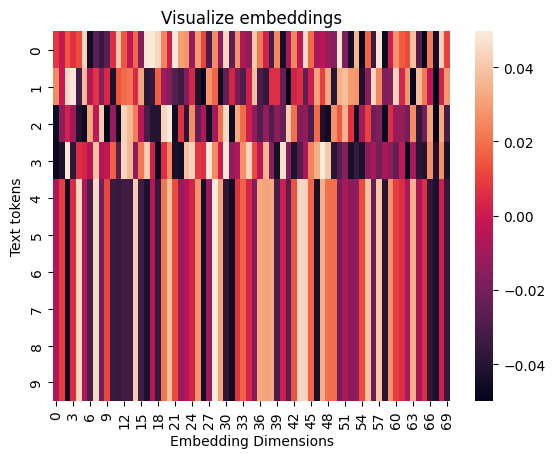

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sample_text = "This is an example"
vectorized_text = vectorize_layer(sample_text)
embedding_text = embedding_layer(vectorized_text)
print(embedding_text.shape)

ax = sns.heatmap(embedding_text[:10])
ax.set(xlabel ="Embedding Dimensions", ylabel = "Text tokens", title ="Visualize embeddings")
plt.show()


### Step 5: Building a classifier model using Recurrent layer

TensorFlow separates the declaration of RNNCells from the [RNNs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN) that run them. In the code below, we declare two [LSTM cells](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell) and pass them both to the RNN to be run together.

In [ ]:
# Build the model
cells = [tf.keras.layers.LSTMCell(256), tf.keras.layers.LSTMCell(64)]
rnn = tf.keras.layers.RNN(cells)
output_layer = tf.keras.layers.Dense(2)

model = tf.keras.Sequential([vectorize_layer, embedding_layer, rnn, output_layer])

_ = model(["sample input"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  multiple                  0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       multiple                  350000    
                                                                 
 rnn_3 (RNN)                 multiple                  417024    
                                                                 
 dense_3 (Dense)             multiple                  130       
                                                                 
Total params: 767154 (2.93 MB)
Trainable params: 767154 (2.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# test a forward pass
for batch in ds['train'].batch(2):
    logits = model(batch['text']) # output layer will yeild logits i.e raw probabilities
    print("Batch      :", batch['text'].shape)
    print("Batch label:", batch['label'].shape)
    print("===========")
    print("Vectorize  :", vectorize_layer(batch['text']).shape)
    print("Embedding  :", embedding_layer(vectorize_layer(batch['text'])).shape)
    print("Recurrent  :", rnn(embedding_layer(vectorize_layer(batch['text']))).shape)
    print("Dense (out):", output_layer(rnn(embedding_layer(vectorize_layer(batch['text'])))).shape)
    print("===========")
    print("Logits     :", logits.numpy())
    print("Probas     :", tf.nn.softmax(logits).numpy())
    print("Predictions:", np.argmax(tf.nn.softmax(logits), axis=-1))
    print("True label :", batch['label'].numpy())

    loss = tf.keras.losses.binary_crossentropy(tf.one_hot(batch['label'], 2, axis=-1), logits, from_logits=True)
    print("BCE loss   :", loss)

    break

Batch      : (2,)
Batch label: (2,)
Vectorize  : (2, 128)
Embedding  : (2, 128, 70)
Recurrent  : (2, 64)
Dense (out): (2, 2)
Logits     : [[-0.01568499  0.00310757]
 [-0.01442088  0.00324402]]
Probas     : [[0.49530202 0.50469804]
 [0.49558386 0.5044161 ]]
Predictions: [1 1]
True label : [0 0]
BCE loss   : tf.Tensor([0.6978613  0.69757706], shape=(2,), dtype=float32)


Then, to do sentiment analysis, we'll treat this as a classification problem. Because it's only a 2-class problem, we'll use binary cross-entropy and output only one value. Then the output is treated as class zero if it's $<0.5$ and class one if it's $\geq0.5$. We can train this model in the usual way.



### Attention

One way to enhance the performance of sequential models is a mechanism called attention. Essentially, the idea is that in order to process the meaning of a token correctly, it might rely on tokens far away in the sequence. We're going to use Luong-style attention, which is a classic variety first employed in language translation. It's implemented by `tf.keras.layers.Attention`.

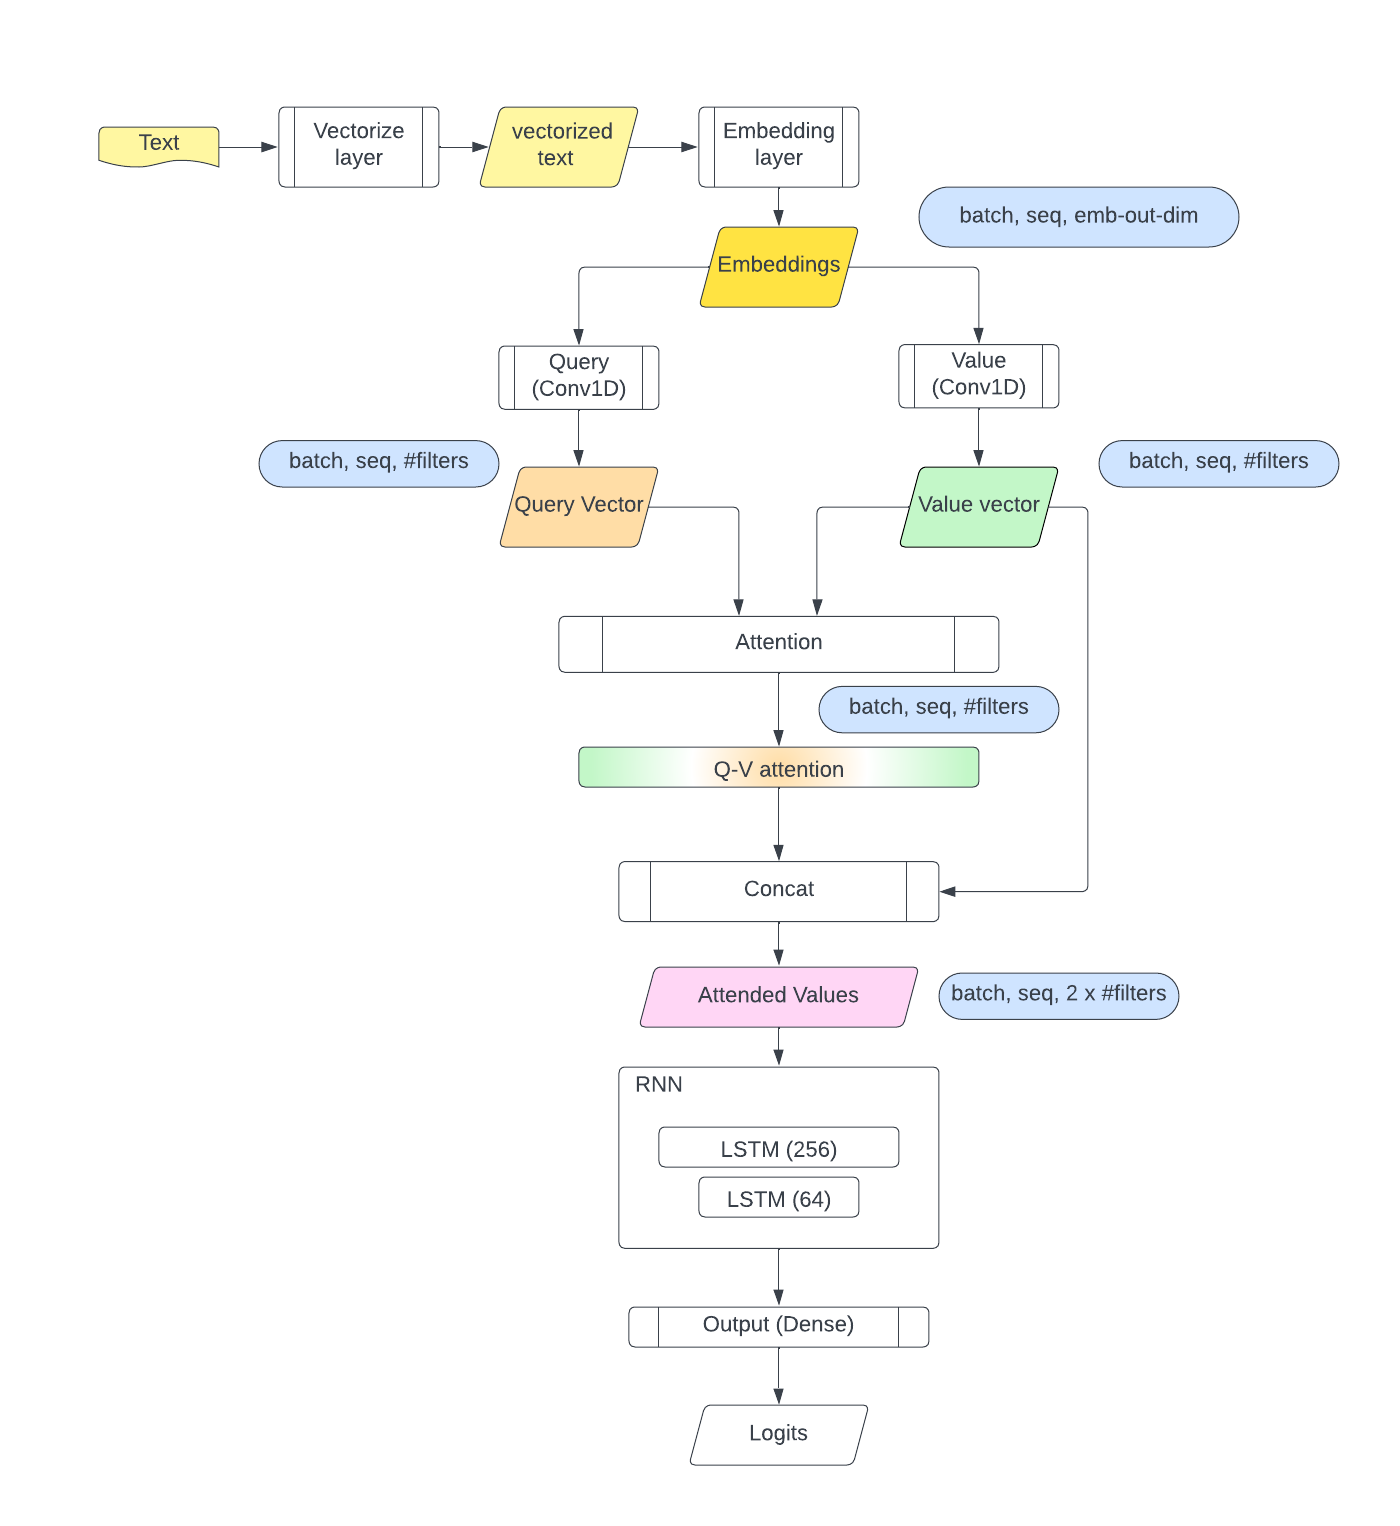

In [ ]:
# We'll make a conv layer to produce the query and value tensors
query_layer = tf.keras.layers.Conv1D(
    filters=100,
    kernel_size=4,
    padding='same')
value_layer = tf.keras.layers.Conv1D(
    filters=100,
    kernel_size=4,
    padding='same')
# Then they will be input to the Attention layer
attention = tf.keras.layers.Attention()
concat = tf.keras.layers.Concatenate()

cells = [tf.keras.layers.LSTMCell(256), tf.keras.layers.LSTMCell(64)]
rnn = tf.keras.layers.RNN(cells)
output_layer = tf.keras.layers.Dense(1)


In [84]:
for batch in ds['train'].batch(1):
    text = batch['text']
    embeddings = embedding_layer(vectorize_layer(text))
    print("Embedding: ", embeddings.shape)
    query = query_layer(embeddings)
    print("Query: ", query.shape)
    value = value_layer(embeddings)
    print("Value: ", value.shape)
    query_value_attention = attention([query, value]) # list of tensors
    print("Shape after attention: ", query_value_attention.shape)
    attended_values = concat([query, query_value_attention])
    print("Shape after concatenating: ", attended_values.shape)
    logits = output_layer(rnn(attended_values))
    loss = tf.keras.losses.binary_crossentropy(tf.expand_dims(batch['label'], -1), logits, from_logits=True)
    print("Loss: ", loss)
    break

Embedding:  (1, 128, 70)
Query:  (1, 128, 100)
Value:  (1, 128, 100)
Shape after attention:  (1, 128, 100)
Shape after concatenating:  (1, 128, 200)
Loss:  tf.Tensor([0.6919346], shape=(1,), dtype=float32)


Inputs are
1. query tensor of shape [batch_size (1), Tq (128), dim (70)],
2. value tensor of shape [batch_size (1), Tv (128), dim (70)] and
3. key tensor of shape [batch_size, Tv, dim] (same as query in this case). The calculation follows the steps:

Calculate
1. **scores** with shape [batch_size, Tq, Tv] as a query-key dot product: scores = tf.matmul(query, key, transpose_b=True).=> ```(128 x 70) (70 x 128) => 128 x 128``` and
```scores.shape = (1, 128, 128)```

2. Use scores to calculate a **distribution** with shape [batch_size, Tq, Tv]: distribution = tf.nn.softmax(scores).
```distribution.shape = (1, 128, 128)```

3. Use distribution to create a linear combination of value with shape [batch_size, Tq, dim]: return tf.matmul(distribution, value).
``` distribution.shape = (1, 128, 128)```

4. value.shape = (1, 128, 70) # value are the weights in the scaled dot product matmul((128, 128), (128, 70)) => 128 x 70

In this way we can produce a very similar RNN over a sequence, but incorporate more dynamic relationships betweeen distant tokens.

### Homework

Nothing. There is no homework in the hackathon this week. 

## Extra

References:

"Attention is all you need"
https://arxiv.org/pdf/1706.03762.pdf

BERT: https://arxiv.org/pdf/1810.04805.pdf

The Illustrated Transformer Blog: http://jalammar.github.io/illustrated-transformer/

## BERT

In [85]:
import tensorflow as tf

In [86]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"

What is MNLI task?
https://cims.nyu.edu/~sbowman/multinli/

Label associations:

0 = contradiction, 1 = entailment, 2 = neutral

In [87]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
model.config

DistilBertConfig {
  "_name_or_path": "huggingface/distilbert-base-uncased-finetuned-mnli",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "dim": 768,
  "dropout": 0.1,
  "eos_token_ids": 0,
  "finetuning_task": "mnli",
  "hidden_dim": 3072,
  "id2label": {
    "0": "contradiction",
    "1": "entailment",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "label2id": {
    "contradiction": "0",
    "entailment": "1",
    "neutral": "2"
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}

In [88]:
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [89]:
print(tokenizer.convert_ids_to_tokens(token_ids.input_ids[0]))

['[CLS]', 'i', 'like', 'soccer', '.', '[SEP]', 'we', 'all', 'love', 'soccer', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


In [90]:
token_ids = tokenizer([("I like soccer.", "We all love soccer!"),
                       ("Joe lived for a very long time.", "Joe is old.")],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [91]:
print(tokenizer.convert_ids_to_tokens(token_ids.input_ids[0]))

['[CLS]', 'i', 'like', 'soccer', '.', '[SEP]', 'we', 'all', 'love', 'soccer', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


In [92]:
outputs = model(**token_ids, return_dict=False)
outputs

(<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[-2.112382  ,  1.178679  ,  1.4101013 ],
        [-0.01478196,  1.0962462 , -0.99199617]], dtype=float32)>,)

In [93]:
outputs = model(**token_ids, return_dict=True, output_attentions=True, output_hidden_states=True)
outputs.keys()

odict_keys(['logits', 'hidden_states', 'attentions'])

In [97]:
len(outputs["attentions"])

6

In [98]:
outputs["attentions"][0].shape # batch, heads, seq, seq

TensorShape([2, 12, 15, 15])

In [100]:
attentions=outputs["attentions"][0][0, :, :, :]
attentions.shape

TensorShape([12, 15, 15])

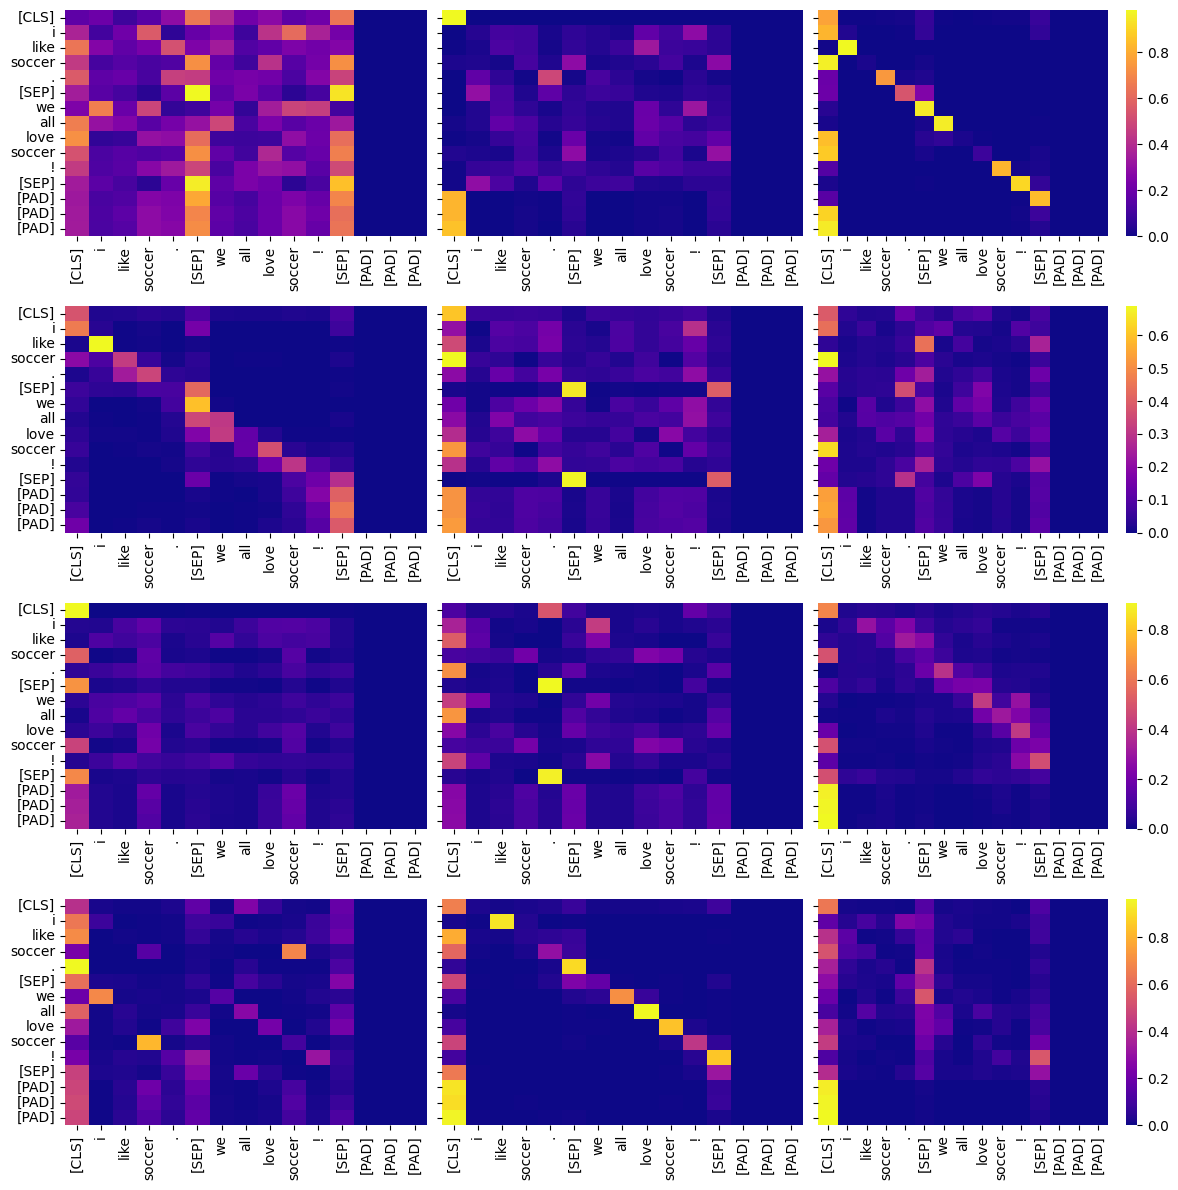

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# visualizing first sample, all attention heads of layer 0 of the encoder
layer_num=0
attentions=outputs["attentions"][layer_num][0, :, :, :] # layer0
attentions.shape

plt.rcParams["figure.figsize"] = [12, 12]
plt.rcParams["figure.autolayout"] = True


fig, ax = plt.subplots(nrows=4, ncols=3, sharey=True) # 12 = 6x2
fig.subplots_adjust(wspace=0.01)

tick_labels = tokenizer.convert_ids_to_tokens(token_ids.input_ids[0])

i=0
for r in range(4):
    for c in range(3):

        cbar=True if c==2 else False

        sns.heatmap(attentions[i],
                    xticklabels=tick_labels,
                    yticklabels=tick_labels,
                    cmap="plasma",
                    ax=ax[r][c],
                    cbar=cbar)
        i+=1

fig.subplots_adjust(wspace=0.001)
fig.tight_layout()
plt.show()

In [ ]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.01619701, 0.43523568, 0.5485673 ],
       [0.2265602 , 0.68817204, 0.08526775]], dtype=float32)>

In [ ]:
Y_pred = tf.argmax(Y_probas, axis=1)
Y_pred  # 0 = contradiction, 1 = entailment, 2 = neutral

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>

## Fine-tuning

In [ ]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences, padding=True, return_tensors="tf").data
y_train = tf.constant([0, 2])  # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 72s 72s/step - loss: 0.3901 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 1s 1s/step - loss: 1.8500 - accuracy: 0.5000


In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### no task head

In [102]:
from transformers import AutoTokenizer, TFDistilBertModel
import tensorflow as tf

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
base_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [103]:
base_model.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [104]:
base_model.input_signature # input signature of the model with no language head

{'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_ids'),
 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='attention_mask')}

In [105]:
model.input_signature # input signature of the finetunes model

{'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_ids'),
 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='attention_mask')}

In [106]:
base_model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}

In [109]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = base_model(inputs,
                     output_attentions=True,
                     output_hidden_states=True
                     )
outputs.keys()

odict_keys(['last_hidden_state', 'hidden_states', 'attentions'])

A Transformer Block from [this](https://arxiv.org/pdf/1706.03762.pdf) paper

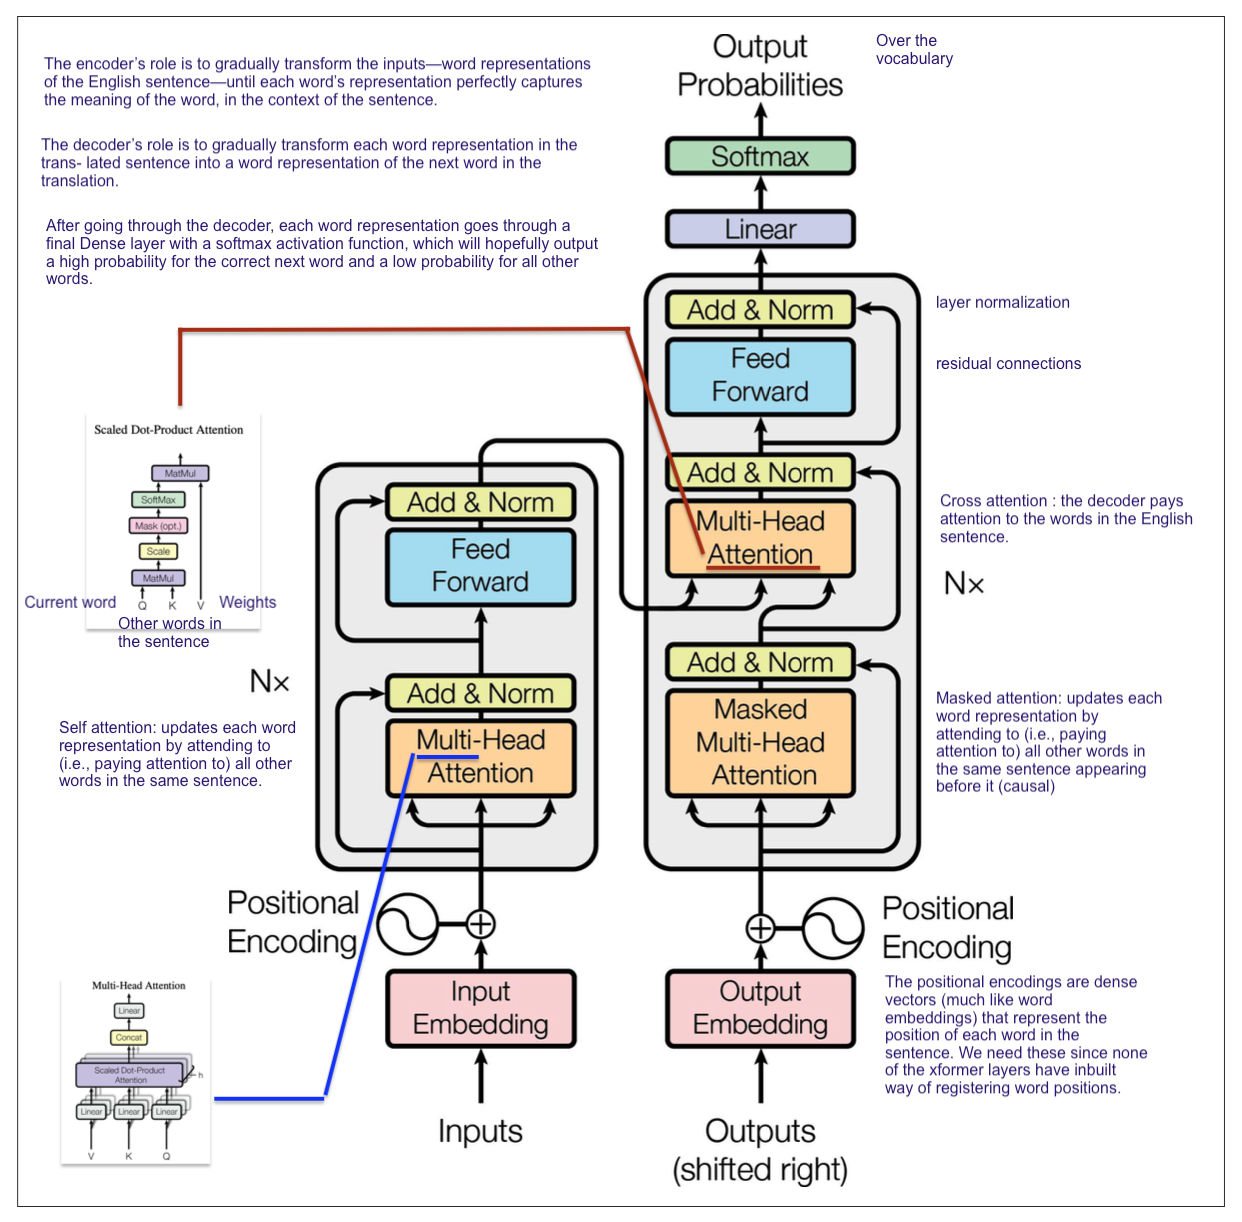